# Digit Recognizer
Taken from: https://www.kaggle.com/competitions/digit-recognizer/

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:



In [17]:
# Dépendances
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA


# Charger les données
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


# Valeurs de C à tester 
# C_values = [1E-2, 1, 1E2]
C_values = [1E-2]

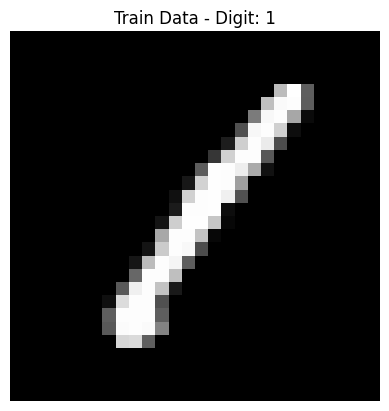

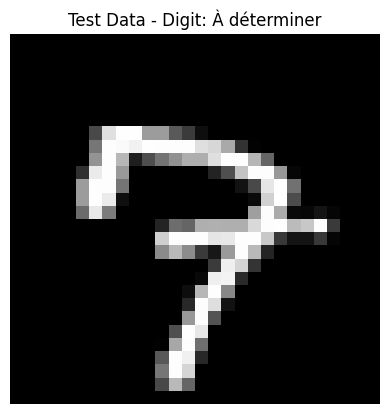

In [18]:
# Fonction d'affichage d'une image de chiffre
def display_digit(data, data_type, row_number, digit_value="À déterminer"):
    """
    Affiche une image à partir des données d'un fichier train.csv ou test.csv.
    """
    if data_type == 'train':
        label = data.iloc[row_number, 0]
        pixel_values = data.iloc[row_number, 1:].values
        title = f"Train Data - Digit: {label}"
    elif data_type == 'test':
        pixel_values = data.iloc[row_number].values
        title = f"Test Data - Digit: {digit_value}"
    else:
        raise ValueError("Le type de données doit être 'train' ou 'test'.")

    image = pixel_values.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Afficher la ligne 0 des données d'entrainement
display_digit(train_data, 'train', 0)

# Afficher la ligne 5 des données de test
display_digit(test_data, 'test', 5)

In [19]:
# Fonction pour afficher une matrice de confusion sans diagonale
def plot_error_confusion_matrix(cm, labels, title="Confusion Matrix (Errors Only)"):
    """
    Affiche une matrice de confusion avec les erreurs uniquement (sans la diagonale).
    """
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)  # Supprimer la diagonale

    # Afficher les erreurs
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_no_diag, annot=True, fmt="d", cmap="Reds",
        xticklabels=labels, yticklabels=labels, cbar=True, square=True
    )
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [20]:
# Fonction d'évaluation du modèle
def model_evaluation(model, val_data, val_labels, scaler, pca=None):
    """
    Évalue les performances du modèle avec une matrice de confusion sans diagonale.
    """
    # Préparer les données de validation
    X_val_scaled = scaler.transform(val_data)
    if pca:
        X_val_scaled = pca.transform(X_val_scaled)

    # Prédictions
    y_pred = model.predict(X_val_scaled)

    # Calcul de la matrice de confusion
    cm = confusion_matrix(val_labels, y_pred)
    labels = sorted(set(val_labels))

    print("\nClassification Report:")
    print(classification_report(val_labels, y_pred))

    # Afficher la matrice de confusion sans diagonale
    plot_error_confusion_matrix(cm, labels, title="Error-Focused Confusion Matrix")

In [21]:
# Fonction pour prédire un chiffre spécifique
def predict_digit(model, test_data, scaler, index, pca=None):
    """
    Prédit un chiffre pour une ligne spécifique du test_data.
    """
    X = test_data.values
    X_scaled = scaler.transform(X)
    if pca:
        X_scaled = pca.transform(X_scaled)

    digit = model.predict(X_scaled[index].reshape(1, -1))[0]
    print(f"Predicted digit for index {index}: {digit}")

In [22]:
# Fonction pour sauvegarder les prédictions
def result(model, test_data, scaler, output_file, pca=None):
    """
    Sauvegarde les prédictions dans un fichier CSV.
    """
    X = test_data.values
    X_scaled = scaler.transform(X)
    if pca:
        X_scaled = pca.transform(X_scaled)

    predictions = model.predict(X_scaled)
    submission = pd.DataFrame({"ImageId": range(1, len(predictions) + 1), "Label": predictions})
    submission.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

### Avec un PCA


==== Modèle avec PCA et C=0.01 ====
Précision pour C=0.01: 0.9380


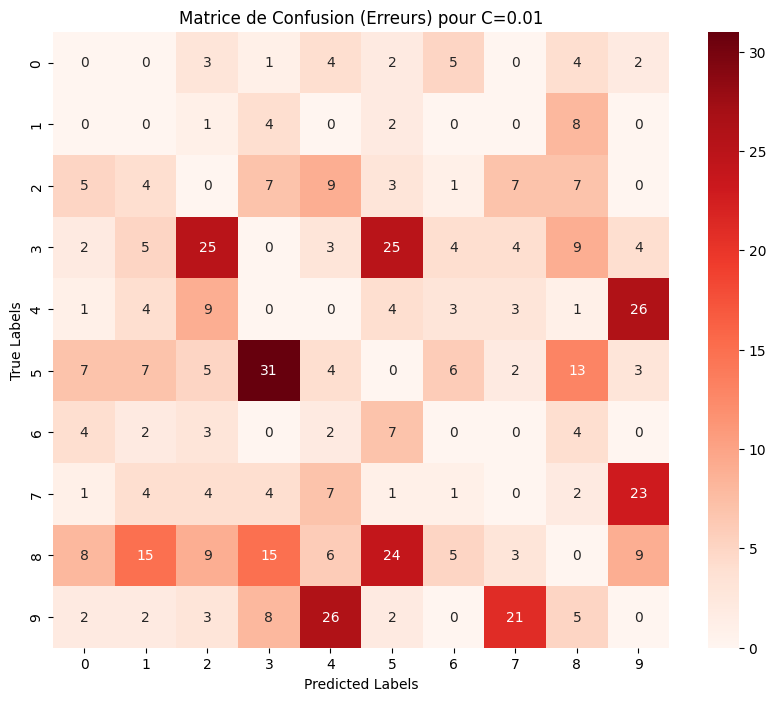

Prédictions enregistrées dans 'prediction_pca.csv'


In [23]:
# Charger et préparer les données
X = train_data.iloc[:, 1:].values  # Pixels (features)
y = train_data.iloc[:, 0].values   # Labels (chiffres)

# Diviser en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Réduire la dimensionnalité avec PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Charger les données de test
X_test = test_data.values  # Les données de test sans labels
X_test_scaled = scaler.transform(X_test)  # Standardiser les données de test
X_test_pca = pca.transform(X_test_scaled)  # Réduire la dimensionnalité des données de test

# Initialiser un DataFrame pour stocker les prédictions
predictions_df = pd.DataFrame()

for C in C_values:
    print(f"\n==== Modèle avec PCA et C={C} ====")
    
    # Définir et entraîner un SVM
    svm = SVC(kernel='linear', C=C, random_state=42)
    svm.fit(X_train_pca, y_train)

    # Prédictions sur l'ensemble de validation
    y_val_pred = svm.predict(X_val_pca)

    # Évaluer les performances
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Précision pour C={C}: {accuracy:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_val, y_val_pred)
    labels = sorted(set(y_val))

    # Afficher la matrice de confusion sans diagonale (erreurs uniquement)
    plot_error_confusion_matrix(cm, labels, title=f"Matrice de Confusion (Erreurs) pour C={C}")

    # Prédictions sur les données de test
    y_test_pred = svm.predict(X_test_pca)  # Utiliser X_test_pca au lieu de X_test_scaled

    # Ajouter les prédictions au DataFrame avec une colonne spécifique
    predictions_df[f"C_{C}"] = y_test_pred

# Enregistrer les prédictions dans un fichier CSV
predictions_df.to_csv("prediction_pca.csv", index_label="Index")
print("Prédictions enregistrées dans 'prediction_pca.csv'")


### Sans PCA


==== Modèle sans PCA et avec C=0.01 ====
Précision pour C=0.01: 0.9377


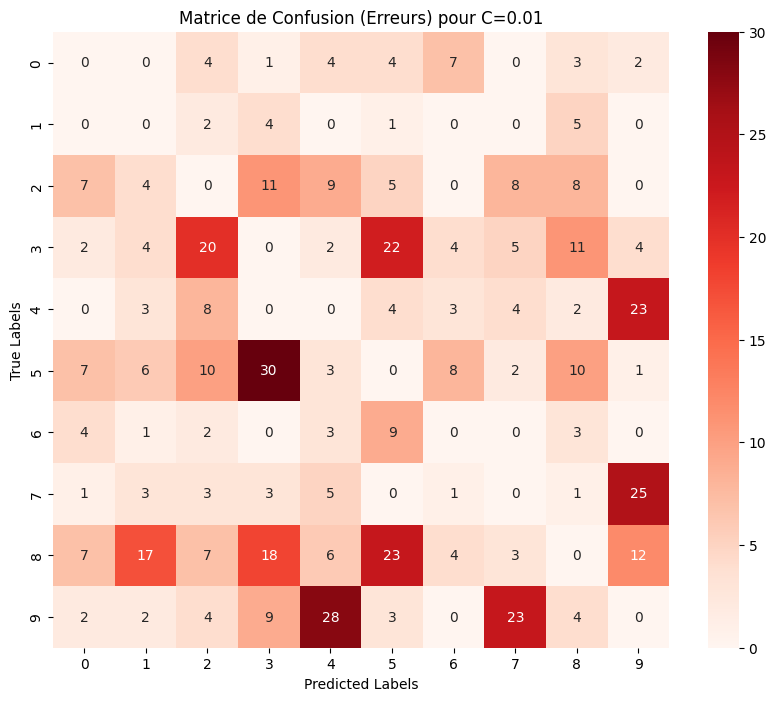

Prédictions enregistrées dans 'prediction_no_pca.csv'


In [24]:
# Charger et préparer les données
X = train_data.iloc[:, 1:].values  # Pixels (features)
y = train_data.iloc[:, 0].values   # Labels (chiffres)

# Diviser en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Charger les données de test
X_test = test_data.values  # Les données de test sans labels
X_test_scaled = scaler.transform(X_test)  # Standardiser les données de test

# Initialiser un DataFrame pour stocker les prédictions
predictions_df = pd.DataFrame()

# Tester différents C
for C in C_values:
    print(f"\n==== Modèle sans PCA et avec C={C} ====")
    
    # Définir et entraîner un SVM
    svm = SVC(kernel='linear', C=C, random_state=42)
    svm.fit(X_train_scaled, y_train)

    # Prédictions sur l'ensemble de validation
    y_val_pred = svm.predict(X_val_scaled)

    # Évaluer les performances
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Précision pour C={C}: {accuracy:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_val, y_val_pred)
    labels = sorted(set(y_val))

    # Afficher la matrice de confusion sans diagonale (erreurs uniquement)
    plot_error_confusion_matrix(cm, labels, title=f"Matrice de Confusion (Erreurs) pour C={C}")

    # ----------------------------------------------------------------
    # Prédictions sur les données de test
    y_test_pred = svm.predict(X_test_scaled)

    # Ajouter les prédictions au DataFrame avec une colonne spécifique
    predictions_df[f"C_{C}"] = y_test_pred

# Enregistrer les prédictions dans un fichier CSV
predictions_df.to_csv("prediction_no_pca.csv", index_label="Index")
print("Prédictions enregistrées dans 'prediction_no_pca.csv'")